<a href="https://colab.research.google.com/github/SY-256/causal-inference/blob/main/Metaleaner%E3%83%BBDML%E3%81%AB%E3%82%88%E3%82%8BATE%E3%81%AE%E6%8E%A8%E5%AE%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 22.5 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.50.0
    Uninstalling shap-0.50.0:
      Successfully uninstalled shap-0.50.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from econml.metalearners import XLearner

In [7]:
# 米国の社会人情報
df_cps = pd.read_csv("/content/cps_controls.csv", index_col=0)
# 失業者の情報（A/Bテストの実施結果が入っている）
df_nsw = pd.read_csv("/content/nsw_dw.csv", index_col=0)

In [5]:
df_cps

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
data_id,,,,,,,,,,
CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670
CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080
CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670
CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670
CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869
...,...,...,...,...,...,...,...,...,...,...
CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352,6801.435,2757.438
CPS1,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.939,11832.240,6895.072
CPS1,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951,1559.371,4221.865


In [6]:
df_nsw

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
data_id,,,,,,,,,,
Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000,0.00,9930.0460
Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000,0.00,3595.8940
Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000,0.00,24909.4500
Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000,0.00,7506.1460
Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000,0.00,289.7899
...,...,...,...,...,...,...,...,...,...,...
Dehejia-Wahba Sample,0.0,21.0,9.0,1.0,0.0,0.0,1.0,31886.430,12357.22,0.0000
Dehejia-Wahba Sample,0.0,28.0,11.0,1.0,0.0,0.0,1.0,17491.450,13371.25,0.0000
Dehejia-Wahba Sample,0.0,29.0,9.0,0.0,1.0,0.0,1.0,9594.308,16341.16,16900.3000


In [9]:
cols = ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']
X_nsw = df_nsw[cols].values
T_nsw = df_nsw["treat"].values
y_nsw = df_nsw["re78"].values

In [10]:
# ATEの計算
ate_nsw = np.mean([y_nsw[T_nsw==1]]) - np.mean([y_nsw[T_nsw==0]])

In [11]:
ate_nsw

np.float64(1794.342404270271)

In [12]:
df_obs = pd.concat([
    df_nsw[df_nsw["treat"]==1], # 処置群のみ抜きだす
    df_cps
], ignore_index=True)

In [13]:
# セレクションバイアスを含んだデータ（完全なA/Bテストの結果ではない）
df_obs

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000,0.000,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000,0.000,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000,0.000,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000,0.000,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000,0.000,289.7899
...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352,6801.435,2757.4380
16173,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.939,11832.240,6895.0720
16174,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951,1559.371,4221.8650
16175,0.0,47.0,9.0,0.0,0.0,1.0,1.0,16914.350,11384.660,13671.9300


In [14]:
X_obs = df_obs[cols].values
T_obs = df_obs["treat"].values
y_obs = df_obs["re78"].values

In [15]:
# XLearnerの学習
xlearner = XLearner(
    models=RandomForestRegressor(n_estimators=100, random_state=42)
)
xlearner.fit(y_obs, T_obs, X=X_obs)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# 交絡因子を与えて推論
ate_estimate = xlearner.ate(X_nsw)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
ate_estimate

np.float64(1715.0782831601762)

In [18]:
# cateの推定
cate = xlearner.effect(X_obs)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [19]:
cate

array([ 8972.0384196 ,  1695.84220531, 12932.78601751, ...,
        4579.01481878, -6474.19118388, -4111.08539878])

In [25]:
df_obs['cate'] = cate

In [26]:
df_obs.dtypes

,0
treat,float64
age,float64
education,float64
black,float64
hispanic,float64
married,float64
nodegree,float64
re74,float64
re75,float64
re78,float64


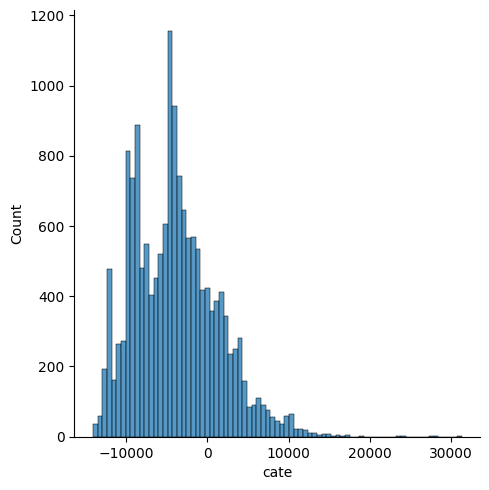

In [27]:
sns.displot(df_obs, x='cate')

In [28]:
df_obs.sort_values(by="cate", ascending=False)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,cate
14524,0.0,28.0,16.0,0.0,0.0,1.0,0.0,0.00,1312.306,0.000,31285.629888
131,1.0,28.0,11.0,1.0,0.0,0.0,1.0,0.00,1284.079,60307.930,31102.501188
10228,0.0,31.0,12.0,1.0,0.0,1.0,0.0,0.00,1172.661,6636.470,27974.410031
15631,0.0,32.0,13.0,0.0,1.0,0.0,0.0,0.00,1305.145,6333.536,27448.208878
2782,0.0,28.0,14.0,1.0,0.0,0.0,0.0,0.00,1063.452,0.000,24193.218819
...,...,...,...,...,...,...,...,...,...,...,...
5332,0.0,30.0,10.0,0.0,0.0,1.0,1.0,23144.82,25243.550,25564.670,-13969.838616
5379,0.0,28.0,11.0,0.0,0.0,1.0,1.0,23783.54,23696.710,25564.670,-13976.526661
6901,0.0,32.0,11.0,0.0,0.0,1.0,1.0,23231.03,21584.130,25564.670,-14019.009427
8843,0.0,27.0,9.0,0.0,0.0,1.0,1.0,23144.82,22968.050,25564.670,-14025.802506


In [29]:
# 年齢で区切る
df_obs["age_10x"] = df_obs["age"] // 10
df_obs["high_school_grad"] = (df_obs["education"] >= 12)

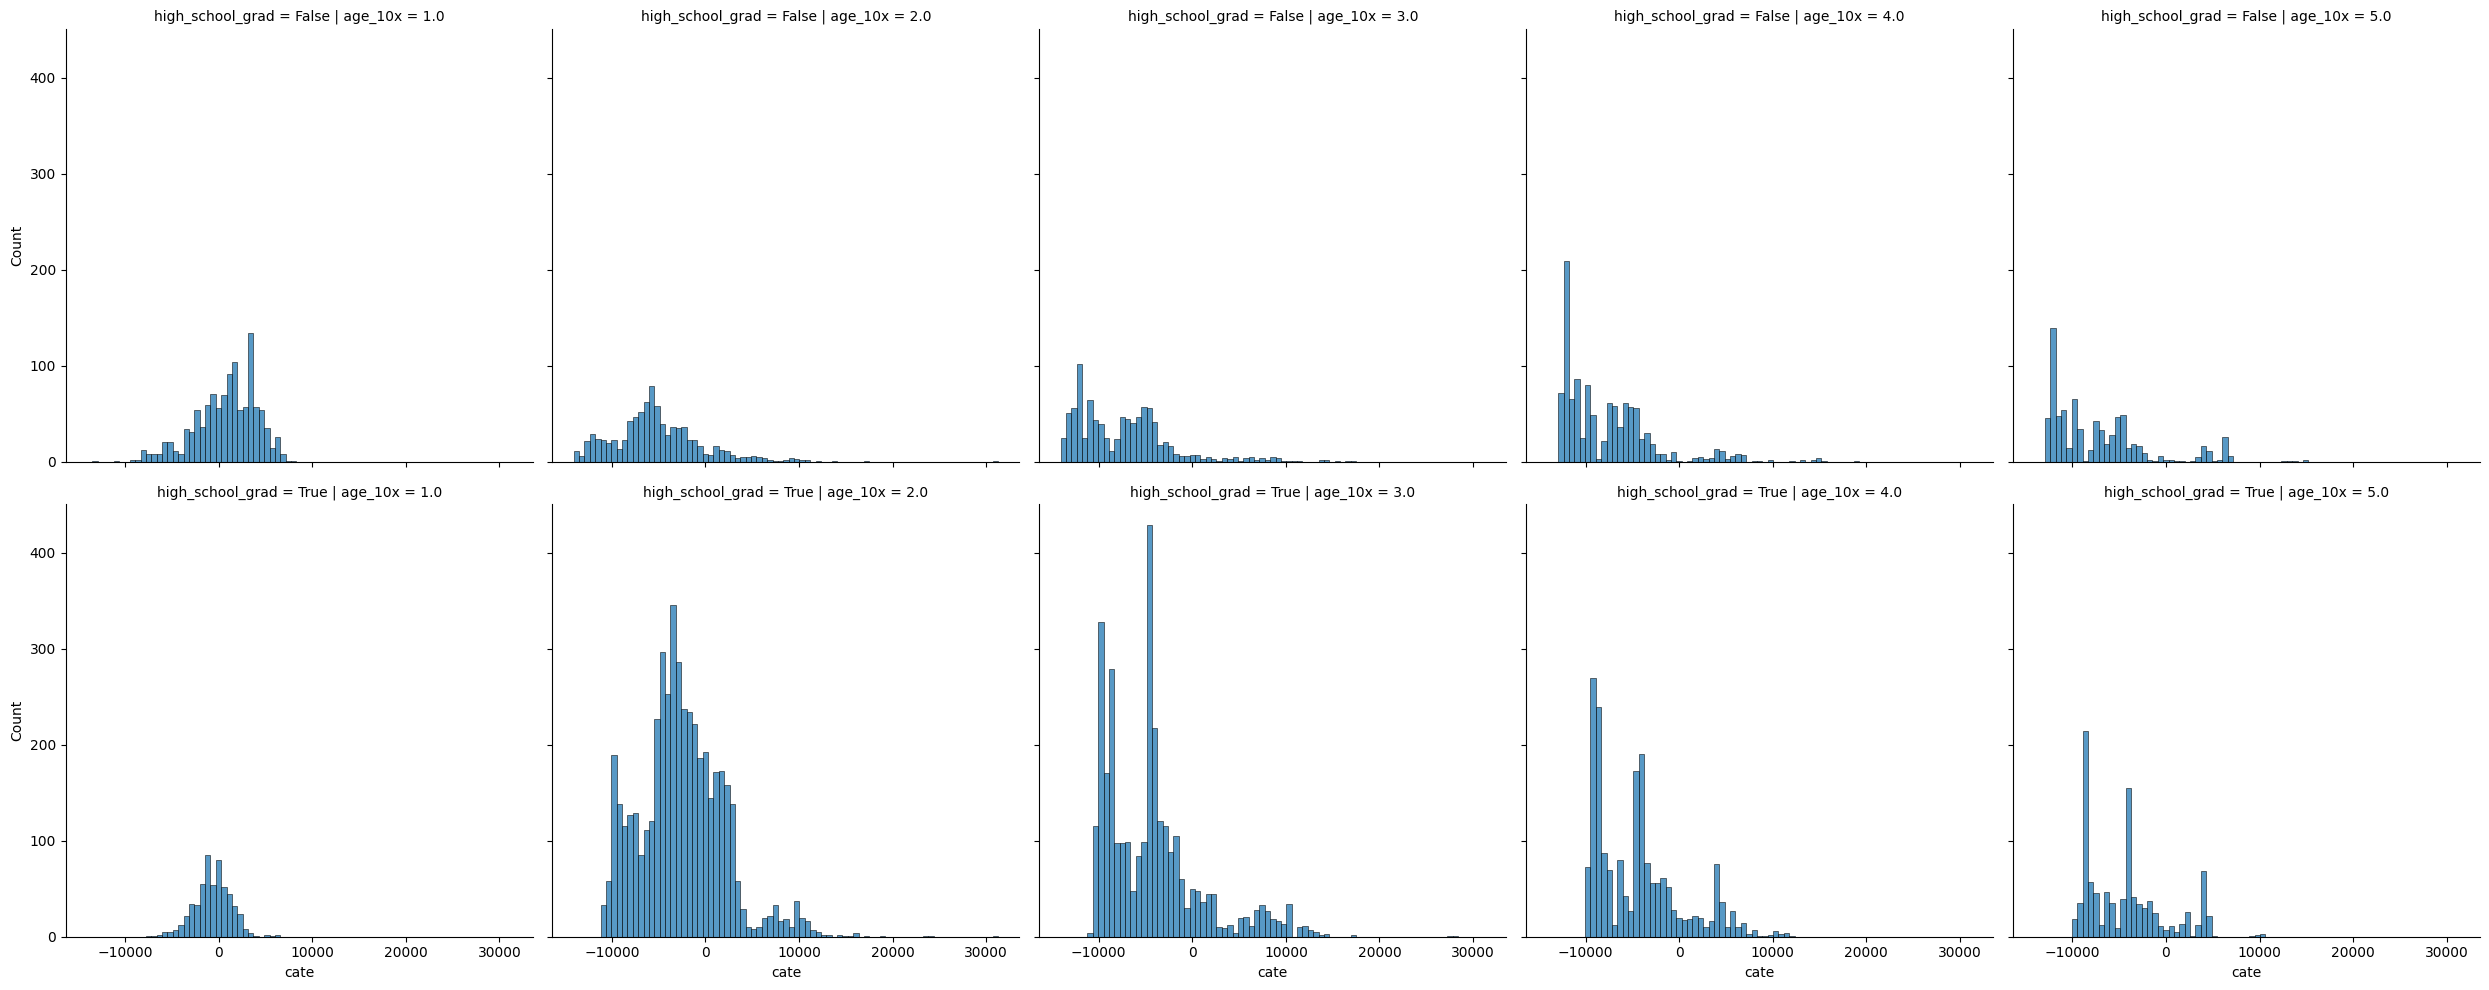

In [31]:
sns.displot(df_obs, x="cate", col="age_10x", row="high_school_grad")

# DMLによるATEの推定

In [33]:
# 追加インポート
from sklearn.ensemble import RandomForestClassifier
from econml.dml import CausalForestDML
from sklearn.model_selection import KFold

In [34]:
# df_obsを訓練データとして利用
model_y = RandomForestRegressor(
    n_estimators=600,
    random_state=42,
    max_depth=5,
    min_samples_leaf=20,
    n_jobs=-1,
    oob_score=True
)

model_t = RandomForestClassifier(
    n_estimators=600,
    max_depth=5,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

dml = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    n_estimators=500,
    min_samples_leaf=50,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    discrete_treatment=True, # 処置項目が離散的かどうか
    random_state=42
)

In [35]:
dml.fit(y_obs, T_obs, X=X_obs)

In [37]:
ate_estimate = dml.ate(X_nsw)

In [38]:
cate = dml.effect(X_obs)

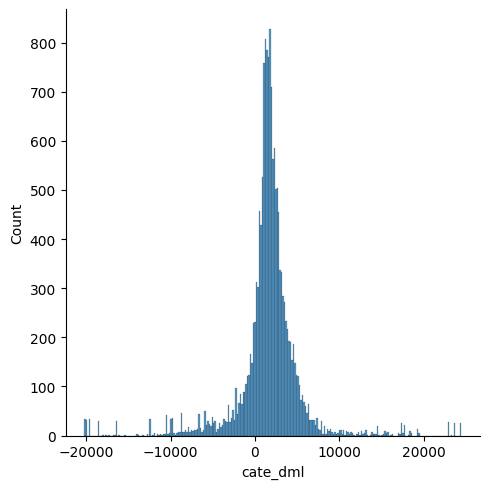

In [39]:
# データが不均衡の場合はXLeanrnerの方が正確性が高い
df_obs["cate_dml"] = cate
sns.displot(df_obs, x="cate_dml")

In [40]:
# XLearnerと異なり年齢が高いほうが効果が高いと出る -> 内容の正確性については検証が必要
df_obs.sort_values(by="cate_dml", ascending=False)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78,cate,age_10x,high_school_grad,cate_dml
7434,0.0,53.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,0.00,-8909.528797,5.0,True,24453.362100
6564,0.0,53.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,25564.67,-8909.528797,5.0,True,24453.362100
6588,0.0,53.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,25564.67,-8909.528797,5.0,True,24453.362100
10706,0.0,53.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,25564.67,-8909.528797,5.0,True,24453.362100
2734,0.0,53.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,25564.67,-8909.528797,5.0,True,24453.362100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8356,0.0,40.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,25564.67,-8974.224969,4.0,True,-20211.396916
7002,0.0,40.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,24636.66,-8974.224969,4.0,True,-20211.396916
10245,0.0,40.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,0.00,-8974.224969,4.0,True,-20211.396916
6100,0.0,40.0,12.0,0.0,0.0,1.0,0.0,25862.32,25243.55,25564.67,-8974.224969,4.0,True,-20211.396916
